In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
import networkx as nx

In [2]:
df_summary = pd.read_csv('../References/London_Multiplex_Transport/Dataset/london_transport_disruptions_summary.txt', sep = ' ', engine='python')
df_summary.head(10)

,#DISRUP_ID,LAYER,STATION_A,STATION_B,FREQUENCY%,DAMAGED_NODES%
0,DISR1,metropolitan,aldgate,bakerstreet,3.3457,2.439
1,DISR2,hammersmith&city,barking,moorgate,2.8914,3.523
2,DISR3,dlr,beckton,canningtown,2.5609,2.439
3,DISR4,overground,claphamjunction,surreyquays,2.0240,1.897
4,DISR5,overground,richmond,willesdenjunction,1.9413,1.626
5,DISR6,northern,edgware,hampstead,1.8174,1.897
6,DISR7,piccadilly,actontown,uxbridge,1.5696,4.065
7,DISR8,overground,claphamjunction,willesdenjunction,1.5696,1.626
8,DISR9,piccadilly,raynerslane,uxbridge,1.5283,1.897
9,DISR10,overground,newcross,westcroydon,1.4457,2.981


In [3]:
nodes_df = pd.read_csv('../References/London_Multiplex_Transport/Dataset/london_transport_nodes.txt', sep = ' ', engine='python')
nodes_df.head(10)

,nodeID,nodeLabel,nodeLat,nodeLong
0,0,abbeyroad,51.531952,0.003738
1,1,westham,51.528526,0.005332
2,2,actoncentral,51.508758,-0.263416
3,3,willesdenjunction,51.532234,-0.243895
4,4,actontown,51.503071,-0.280288
5,5,chiswickpark,51.494371,-0.267723
6,6,turnhamgreen,51.495182,-0.254510
7,7,aldgate,51.514342,-0.075613
8,8,liverpoolstreet,51.517598,-0.082235
9,9,aldgateeast,51.515082,-0.072987


In [4]:
layers = pd.read_csv('../References/London_Multiplex_Transport/Dataset/london_transport_layers.txt', sep = ' ', engine='python')
layers.head(10)

,,,,layerID,layerLabel
1,Tube,(All,underground,lines,aggregated)
2,Overground,NaN,NaN,None,None
3,DLR,NaN,NaN,None,None


In [5]:
edges_file = '../References/London_Multiplex_Transport/Dataset/london_transport_raw.edges'
edges_df = pd.read_csv(edges_file, sep=' ', names=['Line', 'From Station', 'To Station'])

In [9]:
def apply_repulsion(cartesian_df, iterations=100, repulsion_strength=0.01):
    """
    Apply a simple repulsion force to spread out nodes to avoid overlapping.
    
    Parameters:
    - cartesian_df (pd.DataFrame): DataFrame with Cartesian coordinates.
    - iterations (int): Number of iterations for the force-directed algorithm.
    - repulsion_strength (float): Strength of the repulsion force.
    
    Returns:
    - pd.DataFrame: Updated DataFrame with adjusted Cartesian coordinates.
    """
    coords = cartesian_df[['x', 'y']].values
    for _ in range(iterations):
        distances = squareform(pdist(coords))
        # Avoid division by zero and ensure valid distances
        np.fill_diagonal(distances, np.inf)
        with np.errstate(divide='ignore', invalid='ignore'):
            repulsion = np.nan_to_num(repulsion_strength / distances**2, nan=0.0, posinf=0.0, neginf=0.0)
        force_x = np.sum(repulsion * (coords[:, 0][:, np.newaxis] - coords[:, 0]), axis=1)
        force_y = np.sum(repulsion * (coords[:, 1][:, np.newaxis] - coords[:, 1]), axis=1)
        coords[:, 0] += force_x
        coords[:, 1] += force_y
    
    cartesian_df['x'] = coords[:, 0]
    cartesian_df['y'] = coords[:, 1]
    return cartesian_df

def convert_to_cartesian(nodes_df, figsize=(45, 20), iterations=100, repulsion_strength=0.01):
    """
    Convert latitude and longitude to Cartesian coordinates for plotting.
    
    Parameters:
    - nodes_df (pd.DataFrame): DataFrame with columns ['nodeID', 'nodeLabel', 'nodeLat', 'nodeLong'].
    - figsize (tuple): Size of the figure for plotting.
    - iterations (int): Number of iterations for the force-directed algorithm.
    - repulsion_strength (float): Strength of the repulsion force.
    
    Returns:
    - pd.DataFrame: DataFrame with columns ['nodeID', 'nodeLabel', 'x', 'y'] for Cartesian coordinates.
    """
    # Ensure there are no NaN values in latitude and longitude
    nodes_df = nodes_df.dropna(subset=['nodeLat', 'nodeLong'])
    
    # Extract latitudes and longitudes
    latitudes = nodes_df['nodeLat'].values
    longitudes = nodes_df['nodeLong'].values
    
    # Normalize latitudes and longitudes to range [0, 1]
    scaler = MinMaxScaler()
    normalized_coords = scaler.fit_transform(np.column_stack((latitudes, longitudes)))
    
    # Scale to the size of the figure
    fig_width, fig_height = figsize
    scaled_lats = normalized_coords[:, 0] * fig_height
    scaled_longs = normalized_coords[:, 1] * fig_width
    
    # Create a DataFrame with Cartesian coordinates
    cartesian_df = pd.DataFrame({
        'nodeID': nodes_df['nodeID'],
        'nodeLabel': nodes_df['nodeLabel'],
        'x': scaled_longs,
        'y': scaled_lats
    })
    
    # Apply repulsion to spread out nodes
    cartesian_df = apply_repulsion(cartesian_df, iterations, repulsion_strength)
    
    return cartesian_df

cartesian_df = convert_to_cartesian(nodes_df)

print(cartesian_df)

     nodeID          nodeLabel          x          y
0         0          abbeyroad  45.454975  13.022135
1         1            westham  45.940509  10.483691
2         2       actoncentral   6.626894   3.285464
3         3  willesdenjunction   9.156981  11.330164
4         4          actontown   4.164574   0.338298
..      ...                ...        ...        ...
364     364    watfordjunction   2.255589  30.545701
365     365       westfinchley  18.542841  29.373126
366     366        westruislip  -7.510348  14.211634
367     367          wimbledon  13.539657 -13.981186
368     368      wimbledonpark  15.995469 -12.226009

[369 rows x 4 columns]


In [10]:
def assign_line_colors(edges_df):
    line_colors = {
        'bakerloo': 'brown',
        'circle': 'yellow',
        'district': 'green',
        'hammersmith&city': 'pink',
        'jubilee': 'gray',
        'metropolitan': 'purple',
        'northern': 'black',
        'piccadilly': 'blue',
        'victoria': 'cyan',
        'waterloo&city': 'lightblue',
        'overground': 'orange',
        'dlr': 'lightblue',
        'central': 'red'  # Adding Central line for completeness
    }
    
    line_stations = {}
    for line in line_colors:
        line_stations[line] = set(edges_df[edges_df['Line'] == line]['From Station']).union(set(edges_df[edges_df['Line'] == line]['To Station']))
    
    return line_colors, line_stations

In [11]:
def plot_tube_network(nodes_df, edges_df):
    # Convert nodes to Cartesian coordinates
    cartesian_df = convert_to_cartesian(nodes_df)
    
    # Assign colors to lines
    line_colors, line_stations = assign_line_colors(edges_df)
    
    # Create a graph
    G = nx.Graph()
    
    # Add nodes with positions
    pos = {}
    for _, row in cartesian_df.iterrows():
        pos[row['nodeLabel']] = (row['x'], row['y'])
    
    # Add nodes with colors
    node_color_map = {}
    for line, stations in line_stations.items():
        for station in stations:
            G.add_node(station)
            if station in pos:
                node_color_map[station] = line_colors[line]
            else:
                node_color_map[station] = 'gray'  # Station not in nodes_df
    
    # Add edges with colors
    for _, row in edges_df.iterrows():
        line = row['Line']
        if row['From Station'] in line_stations[line] and row['To Station'] in line_stations[line]:
            G.add_edge(row['From Station'], row['To Station'], color=line_colors[line])
        else:
            G.add_edge(row['From Station'], row['To Station'], color='gray')  # Edge not valid
    
    # Draw the graph
    plt.figure(figsize=(45, 20))
    nx.draw(G, pos, with_labels=True, node_size=500, font_size=12, node_color=list(node_color_map.values()), font_color='black', edge_color=[G[u][v]['color'] for u, v in G.edges()], width=2, alpha=0.7)
    
    # Create custom legend for line colors
    legend_patches = []
    for line, color in line_colors.items():
        legend_patches.append(plt.Line2D([], [], color=color, label=line.capitalize(), linestyle='-'))
    
    plt.legend(handles=legend_patches)
    
    plt.title('TfL Station Network with Multiple Tube Lines Highlighted', fontsize=20)
    plt.show()


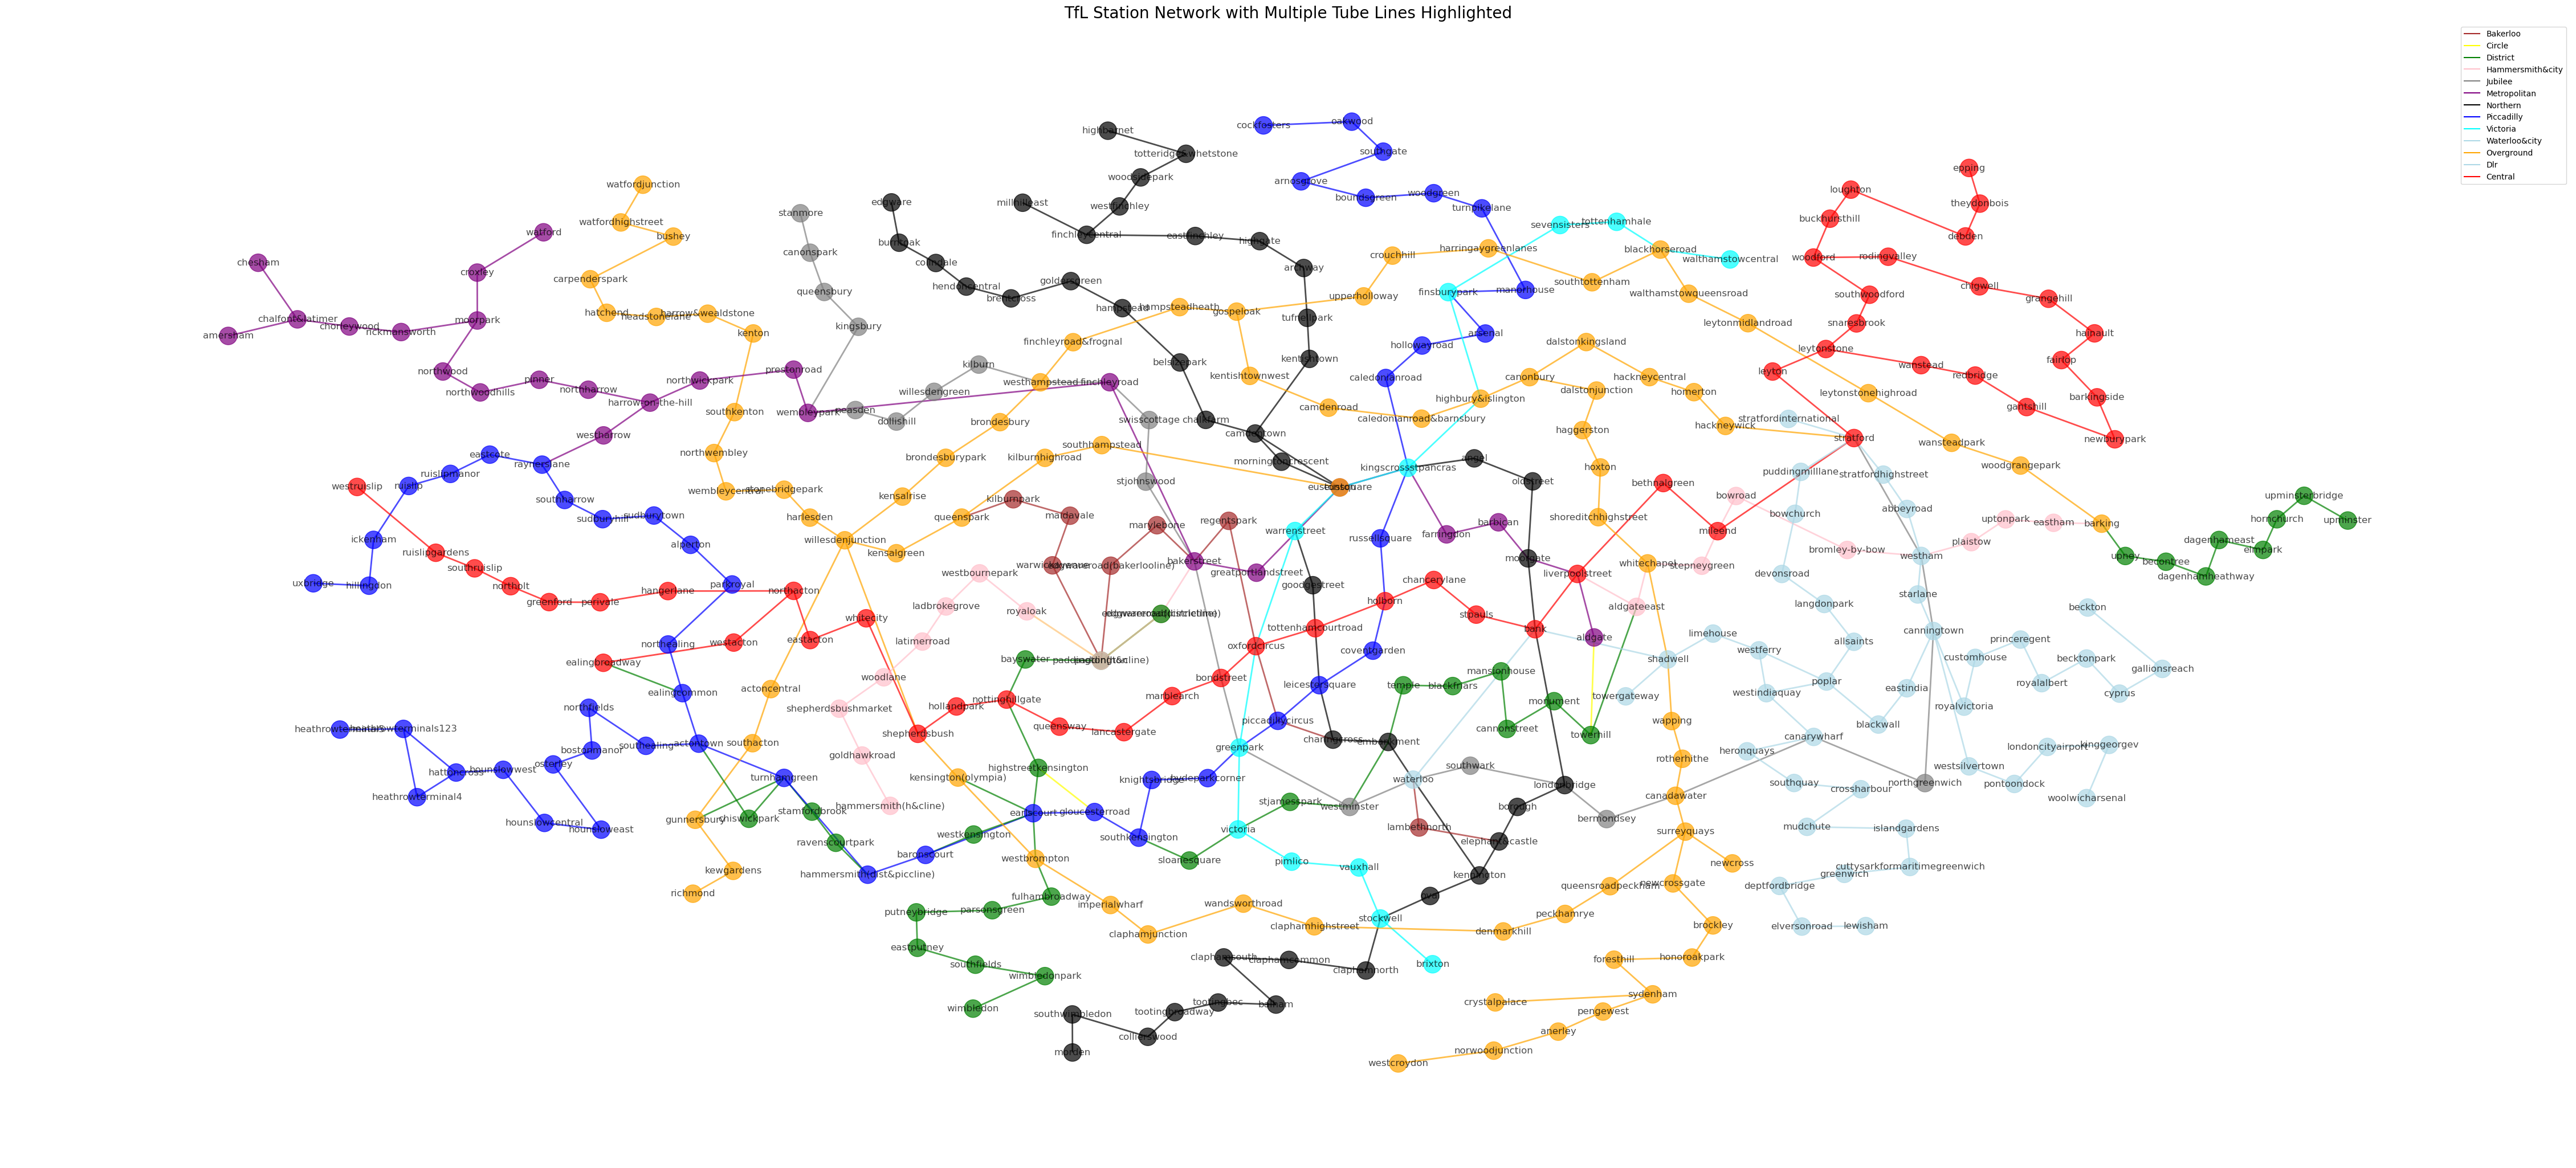

In [12]:
plot_tube_network(nodes_df, edges_df)